# Importy

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt

import eurostat_lib as el
import yfinance as yf

# Obligacje

In [4]:
class Obligacja:
    
    def __init__(self,
                 K: float,
                 okres: str,
                 typ_oprocentowania: str,
                 kapitalizacja: str,
                 kiedy_odsetki: str,
                 r0: float, 
                 r_ref: float | np.ndarray | None = None, 
                 r_cpi: float | np.ndarray | None = None,
                 marża: float = 0.0):
        
        assert isinstance(K, int) or isinstance(K, float), ''
        assert isinstance(r0, int) or isinstance(r0, float), ''
        
        assert kapitalizacja in ['brak', 'miesięczna', 'roczna'], ''
        
        self.okres, self.lata = self.decode_okres(okres) # self.okres = liczba miesięcy, self.lata = liczba pełnych lat
        
        assert typ_oprocentowania in ['stałe', 'zmienne-REF', 'zmienne-CPI'], ''
        if typ_oprocentowania == 'stałe': r = np.array([r0]*self.okres)
        elif typ_oprocentowania == 'zmienne-REF':
            assert r_ref is not None, ''
            if isinstance(r_ref, int) or isinstance(r_ref, float): r_ref = np.array([r_ref] * (self.okres - 1))
            assert isinstance(r_ref, np.ndarray) and r_ref.shape == (self.okres-1, ), ''
            r = np.array([r0] + list(r_ref + marża))
            
        elif typ_oprocentowania == 'zmienne-CPI':
            assert r_cpi is not None, ''
            if isinstance(r_cpi, int) or isinstance(r_cpi, float): r_cpi = np.array([r_cpi] * (self.okres - 1))
            assert isinstance(r_cpi, np.ndarray) and r_cpi.shape == (self.okres-1, ), ''
            r = np.array([r0] + list(r_cpi + marża))
        
        else:
            r = -1.0
            
        assert kiedy_odsetki in ['na koniec', 'co miesiąc', 'co roku'], ''
        
        self.K = K
        self.kiedy_odsetki = kiedy_odsetki
        self.kapitalizacja = kapitalizacja
        
        self.r = self.strumień_oprocentowania(r)
        self.odsetki = self.K * (self.r - 1.0)
        
        self.wypłaty = self.strumień_wypłat(self.odsetki)
        
    def plot_pct(self, **kwargs):
                
        indeks = np.arange(1, len(self.r)+1, step=1, dtype=np.int16)
        
        fig, ax = plt.subplots(**kwargs)
        
        ax.scatter(indeks, self.r, s = 40, label = 'Oprocentowanie')
        ax.set_ylim(bottom = 0.95, top = np.max(self.r)*1.1)
        
        for i in np.where(self.wypłaty > 0):
            ax.vlines(i+1, 0, self.r[i], colors='red')
            ax.scatter(i+1, self.r[i], c='red', s = 20, label = 'Wypłata')
            
        ax.hlines(y=1.0, xmin=0, xmax=self.okres, linestyles='dashed', colors='red')
        ax.grid()
        ax.set_xlabel('Miesiące')
        ax.set_ylabel('Oprocentowanie [%]')
        ax.legend()
        
        ax.set_title(f"Strumień oprocentowania obligacji z zaznaczonymi momentami wypłat")
        plt.show()
        
    def plot_pay(self, **kwargs):
                
        indeks = np.arange(1, len(self.wypłaty)+1, step=1, dtype=np.int16)
        
        fig, ax = plt.subplots(**kwargs)
        
        ax.scatter(indeks, self.wypłaty, s = 40)
        ax.set_ylim(bottom = 0, top = np.max(self.wypłaty)*1.1)
        
        for i in np.where(self.wypłaty > 0):
            ax.vlines(i+1, 0, self.wypłaty[i], colors='red')
            ax.scatter(i+1, self.wypłaty[i], c='red', s = 20, label = 'Wypłata')
            
        ax.grid()
        ax.set_xlabel('Miesiące')
        ax.set_ylabel('Wypłaty [PLN]')
        ax.legend()
        
        ax.set_title(f"Strumień wypłat obligacji")
        plt.show()
        
    def decode_okres(self, okres: str) -> tuple[int, int]:
        
        assert okres[-1] in ['M', 'Y'], ''
        
        if okres[-1] == 'M':
            o = int(okres[:-1])
            l = 0
            
        elif okres[-1] == 'Y':
            l = int(okres[:-1])
            o = int(12*l)
        
        else:
            o, l = -1, -1
            
        return o, l
    
    def strumień_wypłat(self, odsetki: np.ndarray) -> np.ndarray:
            
        if self.kiedy_odsetki == 'na koniec': 
            wypłaty = np.array([0.0] * (self.okres - 1) + [odsetki[-1]])
        
        elif self.kiedy_odsetki == 'co miesiąc':
            wypłaty = odsetki
            
        else: # self.kiedy_odsetki == 'co roku'
            wypłaty = []
            for t in range(0, self.lata):
                wypłaty += [0.0] * (12 - 1) + [odsetki[12*(t+1) - 1]]
            wypłaty = np.array(wypłaty)
            
        return wypłaty
    
    def strumień_oprocentowania(self, r: float | np.ndarray) -> np.ndarray:
    
        assert isinstance(r, np.ndarray), "Argument 'r' musi być typu np.array"
        
        if self.kapitalizacja == 'brak' and self.kiedy_odsetki == 'co miesiąc':
            r = 1.0 + (1.0/12.0)*(r/100.0)
                
        elif self.kapitalizacja == 'brak' and self.kiedy_odsetki == 'co roku':
            r = (1.0/12.0)*(r/100.0)
            for t in range(0, self.lata):
                r[12*t:12*(t+1)] = 1.0 + np.cumsum(r[12*t:12*(t+1)])
        
        elif self.kapitalizacja == 'brak' and self.kiedy_odsetki == 'na koniec':
            r = (1.0/12.0)*(r/100.0)
            r = 1.0 + np.cumsum(r)
            
        elif self.kapitalizacja == 'miesięczna' and self.kiedy_odsetki == 'co roku':
            r = 1 + (1.0/12.0)*(r/100.0)
            for t in range(0, self.lata):
                r[12*t:12*(t+1)] = np.cumprod(r[12*t:12*(t+1)])
        
        elif self.kapitalizacja == 'miesięczna' and self.kiedy_odsetki == 'na koniec':
            r = 1 + (1.0/12.0)*(r/100.0)
            r = np.cumprod(r)
                
        elif self.kapitalizacja == 'roczna' and self.kiedy_odsetki == 'na koniec':
            r = (1.0/12.0)*(r/100.0)
            for t in range(0, self.lata):
                r[12*t:12*(t+1)] = (1.0 + np.cumsum(r[12*t:12*(t+1)])) * (1.0 if t == 0 else r[12*t - 1])
        
        else:
            raise Warning(f"Kombinacja: (kapitalizacja = '{self.kapitalizacja}', kiedy_odsetki = '{self.kiedy_odsetki}') nie jest zaimplementowana")
                
        return r
    
    def summary(self):
        
        print(f"Obligacja wypłaci łącznie {np.sum(self.wypłaty):.2f} zł.")
        
        zwrot_proc = np.sum(self.wypłaty)/self.K
        zwrot_proc_pa = zwrot_proc * (12/self.okres)
        print(f"Zwrot [%, total]: {zwrot_proc:.2%}")
        print(f"Zwrot [%, p.a.]: {zwrot_proc_pa:.2%}")

Obligacja wypłaci łącznie 21875.00 zł.
Zwrot [%, total]: 4.37%
Zwrot [%, p.a.]: 4.37%


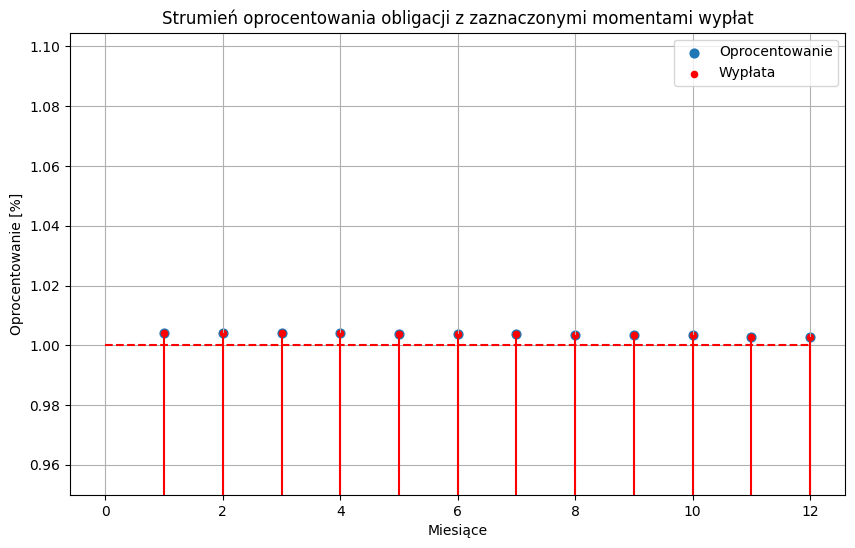

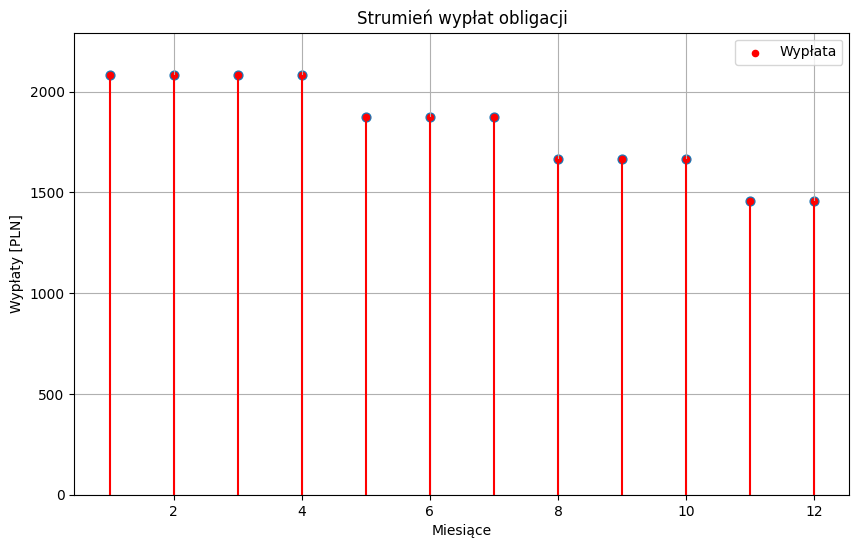

In [3]:
obl = Obligacja(K=500_000.00,
                okres='1Y',
                typ_oprocentowania='zmienne-REF',
                kapitalizacja='brak',
                kiedy_odsetki='co miesiąc',
                r0 = 5.00,
                r_ref = np.array([5.00]*3 + [4.50]*3 + [4.00]*3 + [3.50]*2),
                r_cpi = 2.5,
                marża = 0.0)

obl.summary()

obl.plot_pct(figsize=(10, 6))
obl.plot_pay(figsize=(10, 6))

# Dane ekonomiczne z `Eurostat`

In [7]:
start = '2022-01-01'
countries = ['Poland']

# data = getRATES(start=start, countries=countries).reset_index().merge(
#     getHICP(start=start, countries=countries).reset_index(),
#     how='outer', on='index').merge(
#         getGDP(start=start, countries=countries).reset_index(),
#         how='outer', on='index'
#     )

data = el.getHICP(start=start, countries=countries)
data.tail()

,PL_hicp
2025-06-01,3.4
2025-07-01,2.9
2025-08-01,2.7
2025-09-01,2.9
2025-10-01,2.9


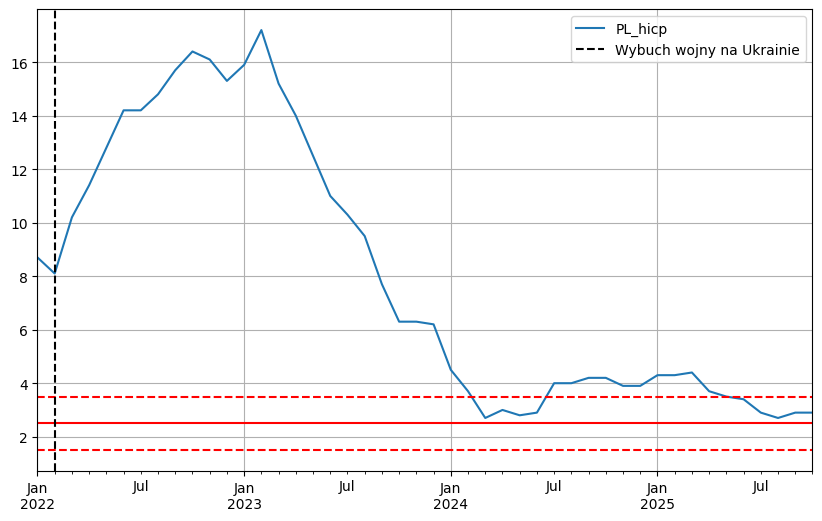

In [6]:
data.loc[:, 'PL_hicp'].dropna().plot(figsize=(10, 6), grid=True)
plt.axhline(2.5, c='red')
plt.axhline(3.5, linestyle='--', c='red')
plt.axhline(1.5, linestyle='--', c='red')

# plt.axvline(x='15-09-2008', ymin=0.0, ymax=17.5, linestyle='--', c='black', label='Kryzys finansowy 2008')
# plt.axvline(x='01-01-2020', ymin=0.0, ymax=17.5, linestyle='--', c='black', label='Umowny początek pandemii COVID')
plt.axvline(x='24-02-2022', ymin=0.0, ymax=17.5, linestyle='--', c='black', label='Wybuch wojny na Ukrainie')

plt.legend()

plt.show()

In [8]:
start = '2020-01-01'
countries = ['Poland']

data = el.getGDP(start=start, countries=countries)
data.head()

,PL_gdp
2020-01-01,598823.4
2020-04-01,554577.9
2020-07-01,594919.5
2020-10-01,612700.1
2021-01-01,635686.4


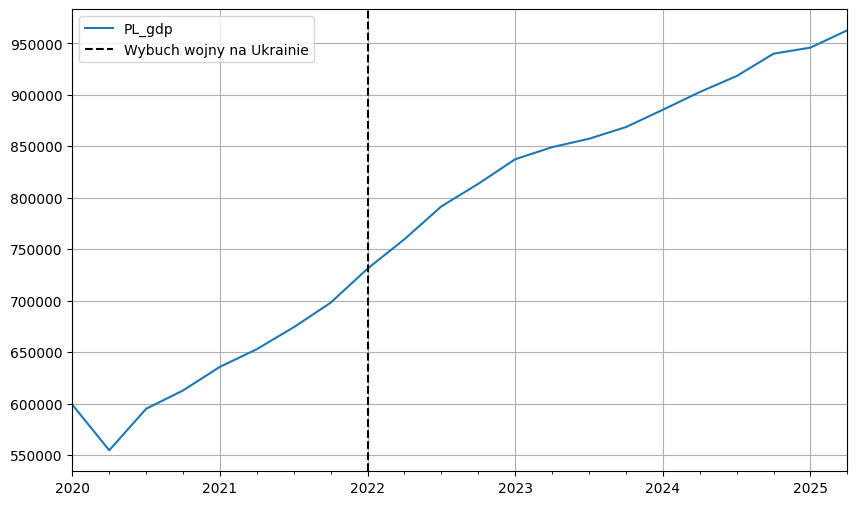

In [11]:
data.loc[:, 'PL_gdp'].dropna().plot(figsize=(10, 6), grid=True)

# plt.axvline(x='15-09-2008', ymin=0.0, ymax=17.5, linestyle='--', c='black', label='Kryzys finansowy 2008')
# plt.axvline(x='01-01-2020', ymin=0.0, ymax=17.5, linestyle='--', c='black', label='Umowny początek pandemii COVID')
plt.axvline(x='24-02-2022', linestyle='--', c='black', label='Wybuch wojny na Ukrainie')

plt.legend()

plt.show()

In [12]:
import yfinance as yf
data = yf.Ticker('ETFBTBSP.WA').history(start='2020-01-01', end='2025-09-13', interval='1d').reset_index()
data['Date'] = data['Date'].apply(lambda el: el.strftime('%Y-%m-%d'))
data.index = data['Date']
data = data[['Close']].rename(columns={'Close': 'ETFBTBSP.WA'})
data

,ETFBTBSP.WA
Date,
2022-01-17,192.500000
2022-01-18,192.360001
2022-01-19,192.940002
2022-01-20,193.339996
2022-01-21,193.759995
...,...
2025-09-08,221.149994
2025-09-09,221.100006
2025-09-10,221.199997


<Axes: xlabel='Date'>

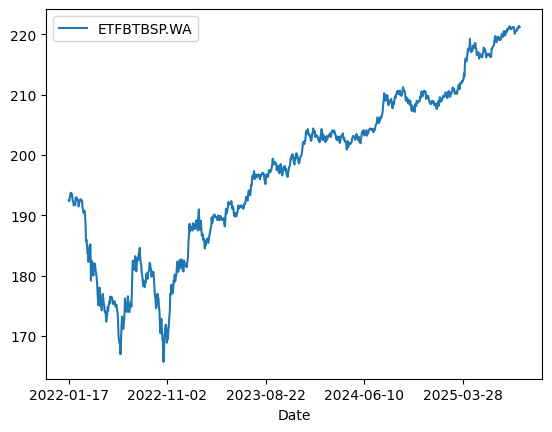

In [13]:
data.plot()

In [65]:
# data = pd.read_csv('^tbsp_d.csv', index_col='Data')[['Zamkniecie']]
# data.rename(columns={'Zamkniecie': 'TBSP.Index'}, inplace=True)
# data

In [66]:
start = '2000-01-01'
countries = ['Poland']

rates = eurostat_lib.getRATES(start=start, countries=countries)
rates.index = [i.strftime('%Y-%m-%d') for i in rates.index]

cpi = eurostat_lib.getHICP(start=start, countries=countries)
cpi.index = [i.strftime('%Y-%m-%d') for i in cpi.index]

In [67]:
main = data.join(rates, how='outer').join(cpi, how='outer').ffill().bfill()
main.index = pd.DatetimeIndex(main.index)

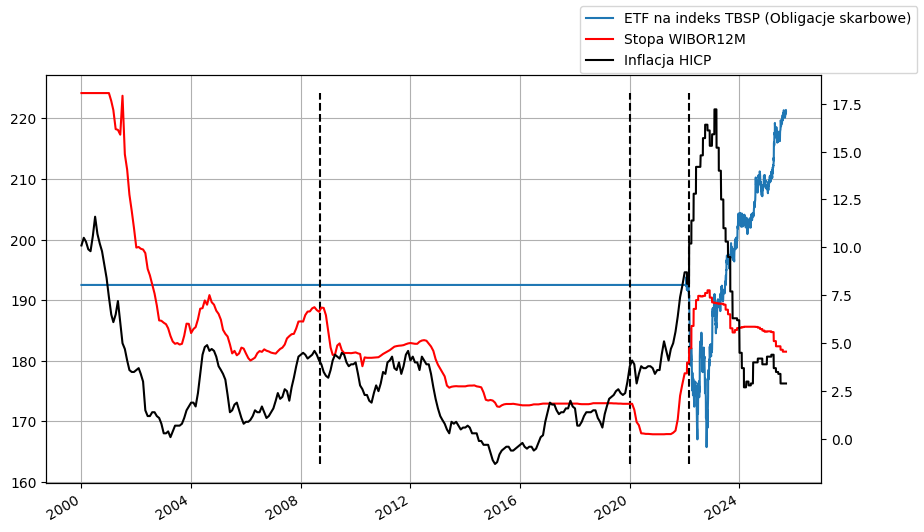

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))


main['ETFBTBSP.WA'].plot(ax=ax, label='ETF na indeks TBSP (Obligacje skarbowe)')

ax1 = ax.twinx()
main['PL_M12_rate'].plot(ax=ax1, color='red', label='Stopa WIBOR12M')
main['PL_hicp'].plot(ax=ax1, color='black', label='Inflacja HICP')

ax.grid(visible=True)

fig.legend()

ymin, ymax = ax.get_ylim()
ax.vlines(x='15-09-2008', ymin=ymin, ymax=ymax, linestyle='--', colors='black', label='Kryzys finansowy 2008')
ax.vlines(x='01-01-2020', ymin=ymin, ymax=ymax, linestyle='--', colors='black', label='Umowny początek pandemii COVID')
ax.vlines(x='24-02-2022', ymin=ymin, ymax=ymax, linestyle='--', colors='black', label='Wybuch wojny na Ukrainie')

plt.show()

In [117]:
symbol = 'EFRB.DE'

etf = yf.Ticker(symbol).history(start='1900-01-01', end='2025-09-13', interval='1d').reset_index()
etf['Date'] = etf['Date'].apply(lambda el: el.strftime('%Y-%m-%d'))
etf.index = pd.DatetimeIndex(etf['Date'])
etf = etf['Close']

In [118]:
start = '2000-01-01'
countries = ['Euro Area']

rates = eurostat_lib.getRATES(start=start, countries=countries)['EA_M12_rate']
rates.index = pd.DatetimeIndex([i.strftime('%Y-%m-%d') for i in rates.index])

In [119]:
main = pd.DataFrame(etf).join(rates, how='outer').bfill().ffill().sort_index()
main.rename(columns={'Close': symbol}, inplace=True)
main

,EFRB.DE,EA_M12_rate
2000-01-01,5.0024,3.9495
2000-02-01,5.0024,4.1114
2000-03-01,5.0024,4.2675
2000-04-01,5.0024,4.3645
2000-05-01,5.0024,4.8485
...,...,...
2025-09-08,5.0734,2.1139
2025-09-09,5.0748,2.1139
2025-09-10,5.0750,2.1139
2025-09-11,5.0744,2.1139


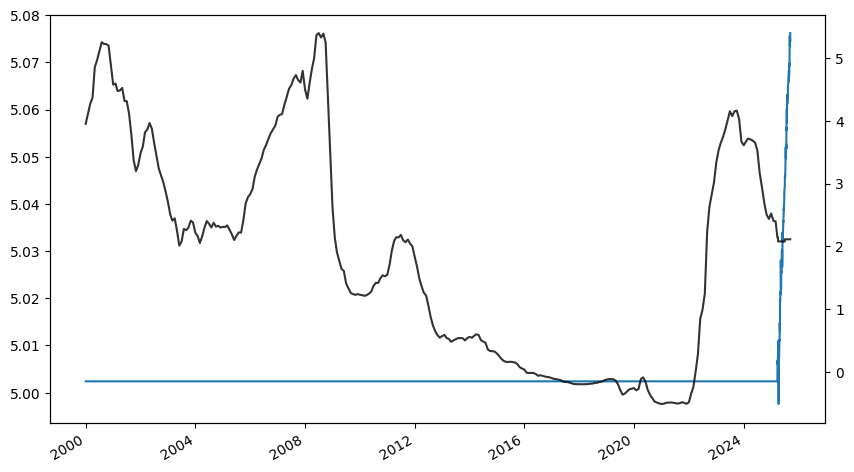

In [120]:
fig, ax = plt.subplots(figsize=(10, 6))

main[symbol].plot(label=f'ETF: {symbol}', ax=ax)

ax1 = ax.twinx()
main['EA_M12_rate'].plot(label='EURIBOR_M12', ax=ax1, color='black', alpha=0.8)

plt.show()

In [13]:
rates = pd.read_csv('fed_rates.csv', sep=';', parse_dates=['Date'])
rates.index = rates['Date']

rates = rates['Value'].str.replace(',', '.').astype(float)
rates.name = 'FED rate'

rates

Date
1954-07-01    1.13
1954-07-02    1.25
1954-07-03    1.25
1954-07-04    1.25
1954-07-05    0.88
              ... 
2025-09-05    4.33
2025-09-08    4.33
2025-09-09    4.33
2025-09-10    4.33
2025-09-11    4.33
Name: FED rate, Length: 25172, dtype: float64

In [40]:
symbol = 'LQDE.L'

etf = yf.Ticker(symbol).history(start='1900-01-01', end='2025-09-13', interval='1d').reset_index()
etf['Date'] = etf['Date'].apply(lambda el: el.strftime('%Y-%m-%d'))
etf.index = pd.DatetimeIndex(etf['Date'])
etf = etf[['Close']]

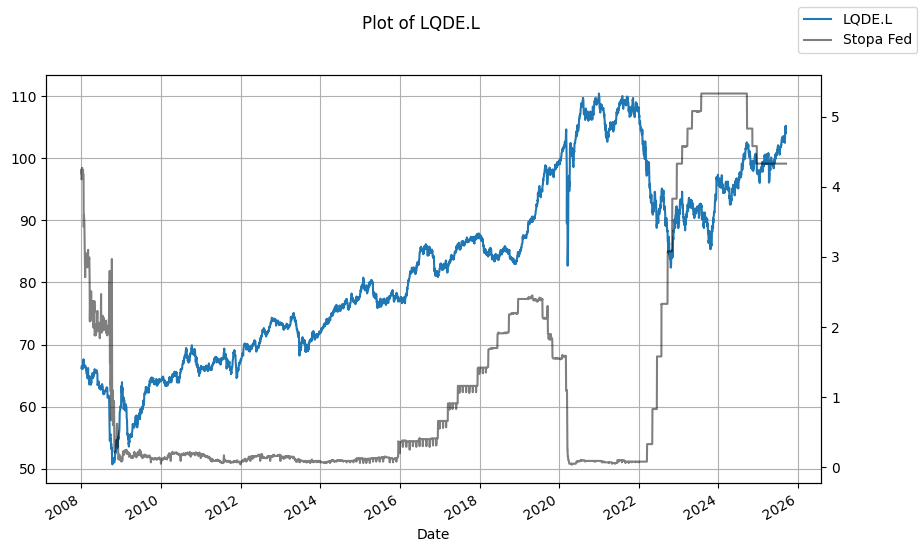

In [41]:
main = etf.join(rates, how='left').sort_index().ffill()

fig, ax = plt.subplots(figsize=(10, 6))

main[f'Close'].plot(label=symbol, ax=ax)

ax_right = ax.twinx()
main['FED rate'].plot(label='Stopa Fed', color='black', ax=ax_right, alpha=0.5)

ax.grid(visible=True)
fig.legend()
fig.suptitle(f'Plot of {symbol}')
plt.show()